<a href="https://colab.research.google.com/github/NataliaBlueCloud/wondernetwork_pings/blob/main/RTT_global_ping_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛰️ Global Internet Latency Analysis (WonderNetwork Dataset)

This notebook reproduces the analysis and visualization of global RTT measurements from the WonderNetwork dataset.
It loads the 2025 measurements, removes outliers, computes average RTT per country, and plots server locations with labeled regional codes (e.g., n₁, we₂, ee₁).

### 1. Clone the Repository
Clone the GitHub repository containing RTT measurement data and helper scripts.


In [ ]:
system('git clone https://github.com/NataliaBlueCloud/wondernetwork_pings.git')

### 2. Install Required Packages

Install all the R libraries used for data handling, visualization, and map generation.
Run this block only once per session.

In [ ]:
install.packages("igraph")
install.packages("R.utils")
install.packages("sf")
install.packages("rnaturalearth")
install.packages("rnaturalearthdata")
install.packages("dplyr")
install.packages("ggrepel")
install.packages("tidyr")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘R.oo’, ‘R.methodsS3’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘e1071’, ‘wk’, ‘classInt’, ‘s2’, ‘units’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘terra’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



### 3. Load Libraries

Load all required R libraries.
These provide functionality for data tables, graphs, geospatial analysis, and plotting.

In [1]:
library(data.table)
library(igraph)
library(ggplot2)
library(R.utils)
library(readxl)
library(sf)
library(rnaturalearth)
library(rnaturalearthdata)
library(dplyr)
library(ggrepel)
library(tidyr)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: R.oo

Loading required package: R.methodsS3

R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.

R.oo v1.27.1 (2025-05-02 21:00:05 UTC) successfully loaded. See ?R.oo for help.


Attaching package: ‘R.oo’


The following object is masked from ‘package:R.methodsS3’:

    throw


The following object is masked from ‘package:igraph’:

    hierarchy


The following objects are masked from ‘package:methods’:

    getClasses, getMethods


The following objects are masked from ‘package:base’:

    attach, detach, load, save


R.utils v2.13.0 (2025-02-24 21:20:02 UTC) successfully loaded. See ?R.utils for help.


Attaching package: ‘R.utils’


The following object is masked from ‘package:utils’:

    timestamp


The following objects are masked from ‘p

### 4. Load RTT and Server Datasets

Load the list of servers and the RTT dataset for January 1, 2025.
Each record represents a Ping measurement between two server locations.

In [2]:
# Load the servers dataset
servers <- fread("/content/wondernetwork_pings/Input_files/servers-2020-07-19.csv")

# Load data
names_df <- c("source", "destination", "timestamp", "min", "avg", "max", "mdev")
# Corrected file path to use the existing 2025-01-01.csv.gz
df <- fread("/content/wondernetwork_pings/Input_files/2025-01-01.csv.gz")
names(df) <- names_df

# Merge with server names to replace IDs with names
df <- merge(df, servers, by.x = "source", by.y = "id")
df <- merge(df, servers, by.x = "destination", by.y = "id", suffixes = c("_src", "_dst"))

# Create a unique list of node names
city_ids <- servers$id
city_names <- servers$name

### 5. Remove Outliers Using IQR Method

Filter out extreme RTT values to eliminate transient anomalies or measurement errors.
This uses the Inter-Quartile Range (IQR) per (source, destination) pair.

In [3]:
# Remove outliers in the 'avg' column using IQR method
# Calculate IQR bounds
# Identify outliers per (source, destination) group
# Function to remove outliers using IQR
initial_n <- nrow(df)

remove_outliers <- function(data) {
  q1 <- quantile(data$avg, 0.25, na.rm = TRUE)
  q3 <- quantile(data$avg, 0.75, na.rm = TRUE)
  iqr <- q3 - q1
  #lower <- q1 - 1000 * iqr #no need the lower
  upper <- q3 + 10000 * iqr
  data[data$avg <= upper]

}

# Apply outlier removal per (source, destination) pair
cleaned_df <- df[, remove_outliers(.SD), by = .(source, destination)]

# Preview the cleaned dataset
head(cleaned_df)

final_n <- nrow(cleaned_df)

# Compute how many were removed
removed_n <- initial_n - final_n
cat("Number of outliers removed:", removed_n, "\n")

# Preview the cleaned dataset
head(cleaned_df)
df = cleaned_df

source destination timestamp           min   avg   max   mdev  name_src  
1 0      0           2025-01-01 00:22:39 0.020 0.033 0.102 0.016 JoaoPessoa
2 0      0           2025-01-01 01:22:39 0.020 0.039 0.183 0.028 JoaoPessoa
3 0      0           2025-01-01 02:22:39 0.019 0.024 0.046 0.007 JoaoPessoa
4 0      0           2025-01-01 03:22:40 0.019 0.030 0.156 0.024 JoaoPessoa
5 0      0           2025-01-01 04:22:39 0.018 0.029 0.045 0.009 JoaoPessoa
6 0      0           2025-01-01 05:22:40 0.020 0.035 0.141 0.021 JoaoPessoa
  title_src   location_src ⋯ longitude_src name_dst   title_dst   location_dst
1 Joao Pessoa Patos        ⋯ -34.8333      JoaoPessoa Joao Pessoa Patos       
2 Joao Pessoa Patos        ⋯ -34.8333      JoaoPessoa Joao Pessoa Patos       
3 Joao Pessoa Patos        ⋯ -34.8333      JoaoPessoa Joao Pessoa Patos       
4 Joao Pessoa Patos        ⋯ -34.8333      JoaoPessoa Joao Pessoa Patos       
5 Joao Pessoa Patos        ⋯ -34.8333      JoaoPessoa Joao Pessoa Patos       
6 Joao Pessoa Patos        ⋯ -34.8333      JoaoPessoa Joao Pessoa Patos       
  state_dst country_dst state_abbv_dst continent_dst latitude_dst longitude_dst
1 Paraiba   Brazil      PB             2             -7.0833      -34.8333     
2 Paraiba   Brazil      PB             2             -7.0833      -34.8333     
3 Paraiba   Brazil      PB             2             -7.0833      -34.8333     
4 Paraiba   Brazil      PB             2             -7.0833      -34.8333     
5 Paraiba   Brazil      PB             2             -7.0833      -34.8333     
6 Paraiba   Brazil      PB             2             -7.0833      -34.8333

Number of outliers removed: 14 


source destination timestamp           min   avg   max   mdev  name_src  
1 0      0           2025-01-01 00:22:39 0.020 0.033 0.102 0.016 JoaoPessoa
2 0      0           2025-01-01 01:22:39 0.020 0.039 0.183 0.028 JoaoPessoa
3 0      0           2025-01-01 02:22:39 0.019 0.024 0.046 0.007 JoaoPessoa
4 0      0           2025-01-01 03:22:40 0.019 0.030 0.156 0.024 JoaoPessoa
5 0      0           2025-01-01 04:22:39 0.018 0.029 0.045 0.009 JoaoPessoa
6 0      0           2025-01-01 05:22:40 0.020 0.035 0.141 0.021 JoaoPessoa
  title_src   location_src ⋯ longitude_src name_dst   title_dst   location_dst
1 Joao Pessoa Patos        ⋯ -34.8333      JoaoPessoa Joao Pessoa Patos       
2 Joao Pessoa Patos        ⋯ -34.8333      JoaoPessoa Joao Pessoa Patos       
3 Joao Pessoa Patos        ⋯ -34.8333      JoaoPessoa Joao Pessoa Patos       
4 Joao Pessoa Patos        ⋯ -34.8333      JoaoPessoa Joao Pessoa Patos       
5 Joao Pessoa Patos        ⋯ -34.8333      JoaoPessoa Joao Pessoa Patos       
6 Joao Pessoa Patos        ⋯ -34.8333      JoaoPessoa Joao Pessoa Patos       
  state_dst country_dst state_abbv_dst continent_dst latitude_dst longitude_dst
1 Paraiba   Brazil      PB             2             -7.0833      -34.8333     
2 Paraiba   Brazil      PB             2             -7.0833      -34.8333     
3 Paraiba   Brazil      PB             2             -7.0833      -34.8333     
4 Paraiba   Brazil      PB             2             -7.0833      -34.8333     
5 Paraiba   Brazil      PB             2             -7.0833      -34.8333     
6 Paraiba   Brazil      PB             2             -7.0833      -34.8333

### 6. Compute Average RTT per Country

Compute the mean RTT for each country (considering both source and destination measurements).
This provides an overall latency profile per geographic area.

In [4]:
country_avg_rtt <- df[, .(Avg_RTT = mean(avg, na.rm=TRUE), latitude=first(latitude_src), longitude=first(longitude_src)), by=country_src]
setnames(country_avg_rtt, "country_src", "country")

country_avg_rtt_dst <- df[, .(Avg_RTT = mean(avg, na.rm=TRUE), latitude=first(latitude_dst), longitude=first(longitude_dst)), by=country_dst]
setnames(country_avg_rtt_dst, "country_dst", "country")

# Merge both source and destination RTTs
country_avg_rtt <- rbind(country_avg_rtt, country_avg_rtt_dst)[, .(Avg_RTT = mean(Avg_RTT, na.rm=TRUE), latitude=first(latitude), longitude=first(longitude)), by=country]

# Load world map
the_world <- ne_countries(scale = "medium", returnclass = "sf")

### 7. Merge RTT Data with World Map

Prepare the world map for plotting.
Fix country name mismatches (e.g., “Czech Republic” → “Czechia”) and merge with RTT statistics.

In [5]:
missing_countries <- setdiff(country_avg_rtt$country, the_world$name)
print("Missing countries not found in world map:")
print(missing_countries)

country_avg_rtt[country == "Czech Republic", country := "Czechia"]
country_avg_rtt[country == "United States", country := "United States of America"]

world_map_data <- merge(the_world, country_avg_rtt, by.x = "name", by.y = "country", all.x = TRUE)

[1] "Missing countries not found in world map:"
[1] "Czech Republic" "United States" 


### 8. Assign Region Codes

Classify each country into broader regions
(e.g., n = North America, we = Western Europe, ee = Eastern Europe, etc.).

In [6]:
assign_region <- function(country) {
  if (country %in% c("United States", "Canada", "Mexico", "Puerto Rico", "Guatemala", "Panama", "Honduras", "Costa Rica"))
    return("n")
  if (country %in% c("United Kingdom", "France", "Germany", "Spain", "Greece", "Italy", "Netherlands",
                     "Belgium", "Switzerland", "Austria", "Sweden", "Norway", "Finland", "Denmark",
                     "Ireland", "Portugal", "Luxembourg", "Iceland", "Malta", "Isle of Man"))
    return("we")
  if (country %in% c("Poland", "Czech Republic", "Hungary", "Romania", "Bulgaria", "Slovakia",
                     "Croatia", "Serbia", "Ukraine", "Lithuania", "Latvia", "Estonia",
                     "Slovenia", "Kosovo", "Moldova", "Russia", "Georgia", "Albania"))
    return("ee")
  if (country %in% c("Australia", "New Zealand"))
    return("az")
  if (country %in% c("Brazil", "Argentina", "Chile", "Colombia", "Peru", "Uruguay",
                     "Ecuador", "Venezuela", "Suriname"))
    return("la")
  if (country %in% c("South Africa", "Egypt", "Nigeria", "Kenya", "Morocco", "Algeria",
                     "Tunisia", "Tanzania", "Ghana", "Uganda"))
    return("af")
  if (country %in% c("United Arab Emirates", "Saudi Arabia", "Israel", "Qatar", "Turkey", "Oman",
                     "Kuwait", "Lebanon", "Cyprus"))
    return("me")
  if (country %in% c("India", "Pakistan", "Bangladesh"))
    return("hi")
  if (country %in% c("Japan", "Singapore", "Malaysia", "Indonesia", "China", "Thailand",
                     "Vietnam", "Philippines", "South Korea", "Cambodia", "Taiwan", "Hong Kong", "Kazakhstan"))
    return("pc")
  return(NA)
}


### 9. Label Servers per Region

Assign server labels using the format region_index (e.g., n₁, we₂).
This makes each node easily identifiable on the map

In [7]:
servers$region_code <- sapply(servers$country, assign_region)

# Add incremental labels (n_1, we_1, etc.)
servers <- servers %>%
  group_by(region_code) %>%
  mutate(server_label = paste0(region_code, "_", row_number())) %>%
  ungroup()


### 10. Reduce Label Clutter for Dense Regions

Limit the number of displayed labels in very dense regions
(North America, Western Europe) to keep the plot readable.

In [8]:
# Show every 2nd or 3rd label depending on region density
servers_labelled <- servers %>%
  group_by(region_code) %>%
  mutate(show_label = ifelse(region_code %in% c("n", "we"), row_number() %% 3 == 0, TRUE)) %>%
  filter(show_label)

### 11. Plot World Map with RTT and Server Labels

Visualize the average RTT per country with server positions and region labels.
Color = average RTT, Labels = regional server codes.

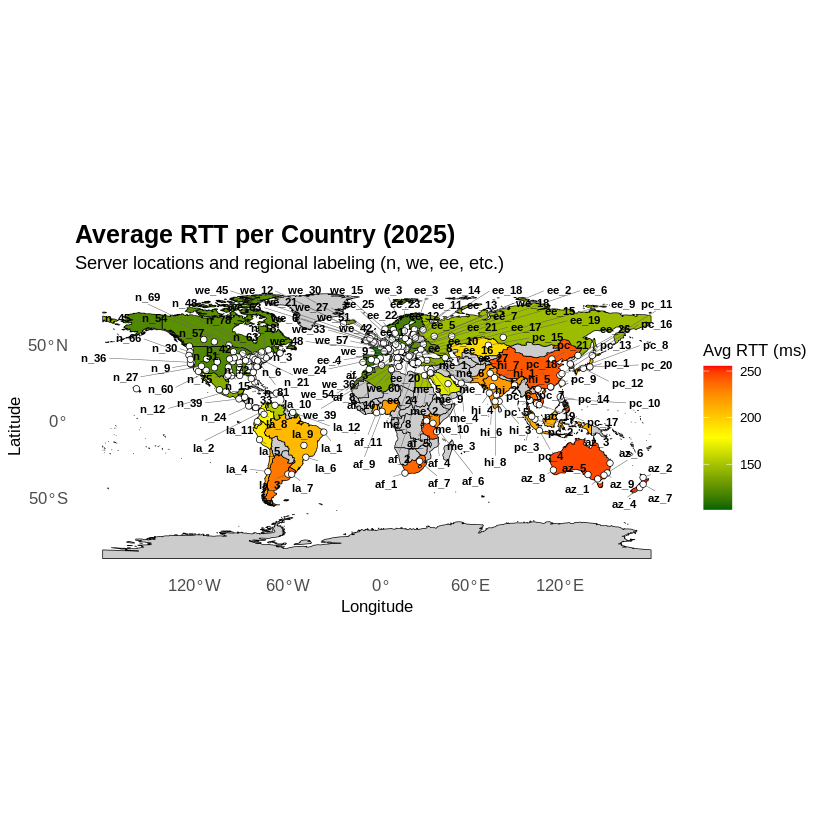

In [9]:
ggplot() +
  geom_sf(data = world_map_data, aes(fill = Avg_RTT), color = "black", size = 0.2) +

  # Server points
  geom_point(data = servers, aes(x = longitude, y = latitude),
             color = "black", fill = "white", size = 1.6, shape = 21, stroke = 0.3) +

  # Smart labels
  geom_text_repel(
    data = servers_labelled,
    aes(x = longitude, y = latitude, label = server_label),
    size = 2.4, fontface = "bold", color = "black",
    segment.size = 0.15, segment.color = "gray40",
    box.padding = 0.25, point.padding = 0.15,
    max.overlaps = 150, min.segment.length = 0
  ) +

  scale_fill_gradientn(colors = c("darkgreen", "yellow", "red"), na.value = "grey80") +

  labs(
    title = "Average RTT per Country (2025)",
    subtitle = "Server locations and regional labeling (n, we, ee, etc.)",
    x = "Longitude", y = "Latitude",
    fill = "Avg RTT (ms)"
  ) +

  theme_minimal(base_size = 10) +
  theme(
    panel.grid = element_blank(),
    axis.text = element_text(size = 10),
    plot.title = element_text(face = "bold", size = 15),
    plot.subtitle = element_text(size = 11)
  )


# ⚡ Triangle Inequality Violation (TIV) Detection and Analysis

This section builds a full-mesh latency graph from the 2025 RTT data, detects Triangle Inequality Violations (TIVs) using Dijkstra’s shortest-path algorithm, and computes the percentage and average gain from detour paths.

In [10]:
##########################################################
# Initialize adjacency matrix with Inf (no direct connection)
adj_matrix <- matrix(Inf, nrow = length(city_names), ncol = length(city_names))
rownames(adj_matrix) <- city_names
colnames(adj_matrix) <- city_names


# # Fill adjacency matrix with average latencies
src_num = 0
for(src in servers$id){
  dst_num = 0
  src_num = src_num + 1
  for(dst in servers$id){
    dst_num = dst_num + 1
    latency = mean(df$avg[df$source == src & df$destination == dst])
    adj_matrix[src_num, dst_num] <- latency
  }
}

### 1. Build the Adjacency Matrix

Construct a full adjacency matrix of average RTT values between all pairs of servers.
Each cell
(𝑖,𝑗) contains the mean RTT from server i to server j.

In [11]:
# Convert NaN or missing values to Inf and process values
adj_matrix_withoutNaN <- apply(adj_matrix, c(1,2), function(x) {
  if (is.nan(x) || is.na(x)) {  # Use is.nan() and is.na() to handle NaN and NA properly
    return(Inf)
  } else {
    return(x)
  }
})

### 2. Handle Missing or NaN Values

Replace missing or undefined RTTs with Inf, ensuring that the graph construction step interprets them as “no link.”

In [12]:
# Create a graph from the adjacency matrix
graph <- graph_from_adjacency_matrix(adj_matrix_withoutNaN, mode = "directed", weighted = TRUE)

### 3. Create the Graph Object

Transform the adjacency matrix into a directed, weighted graph using the igraph package.
Each vertex is a server, and each edge weight is the mean RTT.

### 4. Find Shortest (Detour) Paths and Detect TIVs

For each source–destination pair, compute the direct RTT and the shortest alternative path using Dijkstra’s algorithm.
If the detour path has a lower total RTT, record it as a TIV.

In [13]:
# Empty results table with correct column types
alternative_paths <- data.frame(
  From = character(),
  To = character(),
  Direct = numeric(),
  Alternative = numeric(),
  Improvement = numeric(),
  Alternative_path = character(),
  TIV_present = logical(),
  stringsAsFactors = FALSE
)

# Loop over source/destination pairs
for (i in seq_along(city_names)) {
  for (j in seq_along(city_names)) {
    if (i == j) next

    direct_path <- adj_matrix_withoutNaN[i, j]  # may be NA

    # Dijkstra shortest path
    sp <- igraph::shortest_paths(
      graph,
      from = city_names[i],
      to   = city_names[j],
      weights = igraph::E(graph)$weight
    )

    if (length(sp$vpath[[1]]) > 0) {
      # Sum weights along the path
      sp_weight <- sum(igraph::E(graph, path = sp$vpath[[1]])$weight, na.rm = TRUE)

      # Is the alternative better than the direct edge?
      is_better <- is.finite(direct_path) && !is.na(direct_path) && (sp_weight < direct_path)

      # Nice printable path string
      path_str <- paste(as.character(sp$vpath[[1]]), collapse = " ")

      # Add one row
      alternative_paths <- rbind(
        alternative_paths,
        data.frame(
          From = city_names[i],
          To = city_names[j],
          Direct = direct_path,
          Alternative = if (is_better) sp_weight else NA_real_,
          Improvement = if (is_better) (direct_path - sp_weight) else NA_real_,
          Alternative_path = if (is_better) path_str else NA_character_,
          TIV_present = is_better,
          stringsAsFactors = FALSE
        )
      )

      if (is_better) {
        cat("Alternative path found:", city_names[i], "->", city_names[j],
            "via", path_str, "with latency", sp_weight,
            "ms (Direct:", direct_path, "ms)\n")
      }
    }
  }
}

# Display alternative paths
alternative_paths

Alternative path found: JoaoPessoa -> Melbourne via 1 15 74 38 99 2 with latency 287.6369 ms (Direct: 294.2377 ms)
Alternative path found: JoaoPessoa -> Toronto via 1 164 95 3 with latency 95.31675 ms (Direct: 112.8785 ms)
Alternative path found: JoaoPessoa -> Prague via 1 164 151 4 with latency 172.5075 ms (Direct: 187.6959 ms)
Alternative path found: JoaoPessoa -> Paris via 1 164 5 with latency 152.9517 ms (Direct: 190.5897 ms)
Alternative path found: JoaoPessoa -> Tokyo via 1 164 127 130 6 with latency 225.7612 ms (Direct: 251.2255 ms)
Alternative path found: JoaoPessoa -> Amsterdam via 1 164 7 with latency 156.387 ms (Direct: 177.73 ms)
Alternative path found: JoaoPessoa -> Auckland via 1 15 8 with latency 267.3955 ms (Direct: 275.9598 ms)
Alternative path found: JoaoPessoa -> Moscow via 1 164 13 44 9 with latency 192.6947 ms (Direct: 215.932 ms)
Alternative path found: JoaoPessoa -> Stockholm via 1 164 13 10 with latency 171.3569 ms (Direct: 190.4745 ms)
Alternative path found: Jo

From       To              Direct    Alternative Improvement
1     JoaoPessoa Melbourne       294.23771 287.63688    6.600833  
2     JoaoPessoa Toronto         112.87850  95.31675   17.561750  
3     JoaoPessoa Prague          187.69588 172.50750   15.188375  
4     JoaoPessoa Paris           190.58971 152.95171   37.638000  
5     JoaoPessoa Tokyo           251.22554 225.76121   25.464333  
6     JoaoPessoa Amsterdam       177.73004 156.38700   21.343042  
7     JoaoPessoa Auckland        275.95983 267.39546    8.564375  
8     JoaoPessoa Moscow          215.93200 192.69475   23.237250  
9     JoaoPessoa Stockholm       190.47450 171.35692   19.117583  
10    JoaoPessoa London          166.86392 150.51575   16.348167  
11    JoaoPessoa Dallas          112.45367 106.23929    6.214375  
12    JoaoPessoa NewYork         116.42121  83.10354   33.317667  
13    JoaoPessoa Boston           89.12663  88.53262    0.594000  
14    JoaoPessoa Miami            73.34267        NA          NA  
15    JoaoPessoa Washington       98.69467  87.30446   11.390208  
16    JoaoPessoa Barcelona       206.25921 171.99812   34.261083  
17    JoaoPessoa Atlanta          91.72200  85.84125    5.880750  
18    JoaoPessoa Dublin          160.66104 152.63279    8.028250  
19    JoaoPessoa Vienna          188.74812 174.27421   14.473917  
20    JoaoPessoa Brisbane        293.36925 287.52992    5.839333  
21    JoaoPessoa Chicago         101.83158 100.95871    0.872875  
22    JoaoPessoa SanJose         154.34533 140.01183   14.333500  
23    JoaoPessoa Seattle         148.61992 143.72683    4.893083  
24    JoaoPessoa Tallinn         207.29629 177.31829   29.978000  
25    JoaoPessoa Copenhagen      168.07746 161.94017    6.137292  
26    JoaoPessoa Milan           201.79183 170.26846   31.523375  
27    JoaoPessoa Ljubljana       195.00987 177.55712   17.452750  
28    JoaoPessoa Frankfurt       195.81283 161.69108   34.121750  
29    JoaoPessoa Fremont         158.01771 141.27471   16.743000  
30    JoaoPessoa Singapore       300.98471 286.45837   14.526333  
⋮     ⋮          ⋮               ⋮         ⋮           ⋮          
60241 Douglas    Memphis         116.06225 109.03163    7.0306250 
60242 Douglas    HoChiMinhCity   290.82488 211.76542   79.0594583 
60243 Douglas    Cromwell         98.06987  93.32658    4.7432917 
60244 Douglas    Bern             28.61967  28.33325    0.2864167 
60245 Douglas    Syracuse         94.12754  82.67333   11.4542083 
60246 Douglas    Basel            35.97975  28.23004    7.7497083 
60247 Douglas    Brasilia        205.02521 202.70825    2.3169583 
60248 Douglas    Savannah        134.05950 126.84746    7.2120417 
60249 Douglas    Lyon             17.21617        NA           NA 
60250 Douglas    Algiers          82.74371  70.79542   11.9482917 
60251 Douglas    Caracas         157.82800 156.34929    1.4787083 
60252 Douglas    Lagos           133.26904 121.33829   11.9307500 
60253 Douglas    Koto            249.70108 204.04171   45.6593750 
60254 Douglas    Tbilisi          88.31054  85.39100    2.9195417 
60255 Douglas    Valletta         65.16121  60.56425    4.5969583 
60256 Douglas    Antwerp          28.22404  21.46046    6.7635833 
60257 Douglas    Tunis            56.04467  48.94867    7.0960000 
60258 Douglas    QuebecCity      102.66463  88.77779   13.8868333 
60259 Douglas    BerkeleySprings       Inf        NA           NA 
60260 Douglas    Beirut          166.18588 160.88079    5.3050833 
60261 Douglas    Quito           160.95133 158.09050    2.8608333 
60262 Douglas    Ottawa                Inf        NA           NA 
60263 Douglas    Jerusalem        77.43700  69.73279    7.7042083 
60264 Douglas    Lincoln         121.63050 105.33600   16.2945000 
60265 Douglas    Carlow           24.79296        NA           NA 
60266 Douglas    Zhangjiakou     254.56146 160.49304   94.0684167 
60267 Douglas    Paramaribo            Inf        NA           NA 
60268 Douglas    Cheltenham       16.85237  15.41675 

### 5. Filter Invalid Entries and Compute TIV Statistics

Remove pairs without valid direct RTTs and calculate the percentage of optimized links (i.e., TIV links) and non-optimized ones.

In [17]:
# Display alternative paths
alternative_paths$TIV_gain <- (alternative_paths$Direct - alternative_paths$Alternative) /
  alternative_paths$Alternative * 100

alternative_paths_all_data <- alternative_paths
alternative_paths_TIV_df <- alternative_paths[(alternative_paths$TIV_present == 1), ]
percent_optimized <- (nrow(alternative_paths_TIV_df) / (length(city_names) * (length(city_names) - 1))) * 100

alternative_paths_TIV_df

From       To            Direct    Alternative Improvement
1     JoaoPessoa Melbourne     294.23771 287.63688    6.600833  
2     JoaoPessoa Toronto       112.87850  95.31675   17.561750  
3     JoaoPessoa Prague        187.69588 172.50750   15.188375  
4     JoaoPessoa Paris         190.58971 152.95171   37.638000  
5     JoaoPessoa Tokyo         251.22554 225.76121   25.464333  
6     JoaoPessoa Amsterdam     177.73004 156.38700   21.343042  
7     JoaoPessoa Auckland      275.95983 267.39546    8.564375  
8     JoaoPessoa Moscow        215.93200 192.69475   23.237250  
9     JoaoPessoa Stockholm     190.47450 171.35692   19.117583  
10    JoaoPessoa London        166.86392 150.51575   16.348167  
11    JoaoPessoa Dallas        112.45367 106.23929    6.214375  
12    JoaoPessoa NewYork       116.42121  83.10354   33.317667  
13    JoaoPessoa Boston         89.12663  88.53262    0.594000  
15    JoaoPessoa Washington     98.69467  87.30446   11.390208  
16    JoaoPessoa Barcelona     206.25921 171.99812   34.261083  
17    JoaoPessoa Atlanta        91.72200  85.84125    5.880750  
18    JoaoPessoa Dublin        160.66104 152.63279    8.028250  
19    JoaoPessoa Vienna        188.74812 174.27421   14.473917  
20    JoaoPessoa Brisbane      293.36925 287.52992    5.839333  
21    JoaoPessoa Chicago       101.83158 100.95871    0.872875  
22    JoaoPessoa SanJose       154.34533 140.01183   14.333500  
23    JoaoPessoa Seattle       148.61992 143.72683    4.893083  
24    JoaoPessoa Tallinn       207.29629 177.31829   29.978000  
25    JoaoPessoa Copenhagen    168.07746 161.94017    6.137292  
26    JoaoPessoa Milan         201.79183 170.26846   31.523375  
27    JoaoPessoa Ljubljana     195.00987 177.55712   17.452750  
28    JoaoPessoa Frankfurt     195.81283 161.69108   34.121750  
29    JoaoPessoa Fremont       158.01771 141.27471   16.743000  
30    JoaoPessoa Singapore     300.98471 286.45837   14.526333  
31    JoaoPessoa Warsaw        203.70929 175.24312   28.466167  
⋮     ⋮          ⋮             ⋮         ⋮           ⋮          
60233 Douglas    Liege          20.47146  19.60400    0.8674583 
60235 Douglas    Redding       156.95996 145.54537   11.4145833 
60236 Douglas    Frosinone      54.07012  39.35692   14.7132083 
60237 Douglas    Izmir          64.99346  54.95608   10.0373750 
60239 Douglas    Eindhoven      23.03825  21.15450    1.8837500 
60240 Douglas    Indianapolis  117.35787  99.80625   17.5516250 
60241 Douglas    Memphis       116.06225 109.03163    7.0306250 
60242 Douglas    HoChiMinhCity 290.82488 211.76542   79.0594583 
60243 Douglas    Cromwell       98.06987  93.32658    4.7432917 
60244 Douglas    Bern           28.61967  28.33325    0.2864167 
60245 Douglas    Syracuse       94.12754  82.67333   11.4542083 
60246 Douglas    Basel          35.97975  28.23004    7.7497083 
60247 Douglas    Brasilia      205.02521 202.70825    2.3169583 
60248 Douglas    Savannah      134.05950 126.84746    7.2120417 
60250 Douglas    Algiers        82.74371  70.79542   11.9482917 
60251 Douglas    Caracas       157.82800 156.34929    1.4787083 
60252 Douglas    Lagos         133.26904 121.33829   11.9307500 
60253 Douglas    Koto          249.70108 204.04171   45.6593750 
60254 Douglas    Tbilisi        88.31054  85.39100    2.9195417 
60255 Douglas    Valletta       65.16121  60.56425    4.5969583 
60256 Douglas    Antwerp        28.22404  21.46046    6.7635833 
60257 Douglas    Tunis          56.04467  48.94867    7.0960000 
60258 Douglas    QuebecCity    102.66463  88.77779   13.8868333 
60260 Douglas    Beirut        166.18588 160.88079    5.3050833 
60261 Douglas    Quito         160.95133 158.09050    2.8608333 
60263 Douglas    Jerusalem      77.43700  69.73279    7.7042083 
60264 Douglas    Lincoln       121.63050 105.33600   16.2945000 
60266 Douglas    Zhangjiakou   254.56146 160.49304   94.0684167 
60268 Douglas    Cheltenham     16.85237  15.41675    1.4356250 
60269 Douglas    Falkenstein    32.95996 

### 6. Compute TIV Gain (% Latency Reduction)

For each pair of servers $(i,j)$, the **Triangle Inequality Violation (TIV) gain** is defined as  
the relative improvement between the direct latency and the best detour path latency.

The metric quantifies how much faster an indirect path can be compared to the direct route:

$$
G(i,j) = \frac{d(i,j) - d_{\text{detour}}(i,j)}{d_{\text{detour}}(i,j)} \times 100\%
$$

where:

- $d(i,j)$ — average RTT measured directly between nodes *i* and *j*  
- $d_{\text{detour}}(i,j)$ — total RTT of the shortest indirect (multi-hop) path  

A positive $G(i,j)$ indicates a TIV case — i.e., the detour path provides a lower latency than the direct connection.



In [18]:
# Display alternative paths
alternative_paths$TIV_gain <- (alternative_paths$Direct - alternative_paths$Alternative) /
  alternative_paths$Alternative * 100

avg_TIV_gain <- mean(alternative_paths_TIV_df$TIV_gain)
avg_improvement <- mean(alternative_paths_TIV_df$Improvement)
# Print stats
cat("Percentage of optimized paths:", percent_optimized, "%\n")
cat("Average improvement in RTT:", avg_improvement, "ms\n")


Percentage of optimized paths: 72.28638 %
Average improvement in RTT: 20.73471 ms


### 7. Aggregate TIV Results by Country and City

Combine TIV statistics with geographic data for visualization.

In [19]:
combined_data = alternative_paths_TIV_df

# Merge with server data to get city names and coordinates
combined_data <- merge(combined_data, servers, by.x="From", by.y="name")

# Aggregate RTT improvement by country
country_rtt <- aggregate(Improvement ~ country, data=combined_data, mean)
city_rtt <- aggregate(Improvement ~ From, data=combined_data, mean)


### 8. Visualize Average TIV Gain per City

Plot the average percentage TIV gain per server location.
The color scale indicates the magnitude of improvement.

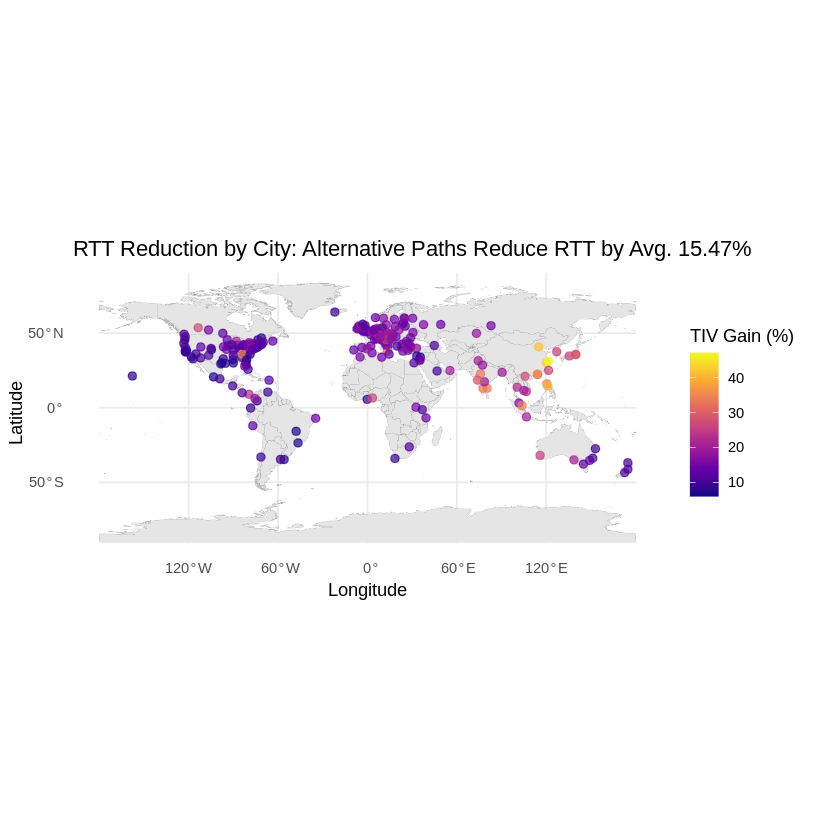

In [20]:
# Aggregate improvement percentage by city
city_rtt <- aggregate(TIV_gain ~ From, data=combined_data, mean)

# Merge with server locations
city_rtt <- merge(city_rtt, servers, by.x="From", by.y="name")

# Load world map
the_world <- ne_countries(scale = "medium", returnclass = "sf")

# Construct dynamic title with mean improvement percentage
mean_improvement <- round(mean(city_rtt$TIV_gain, na.rm=TRUE), 2)
title_text <- paste0("RTT Reduction by City: Alternative Paths Reduce RTT by Avg. ", mean_improvement, "%")

#v2 without size legend
# Plot RTT improvements by city with fixed, smaller point size and no size legend
ggplot() +
  geom_sf(data = the_world, fill = "grey90", color = "black", size = 0.02) +
  geom_point(data = city_rtt, aes(x = longitude, y = latitude, color = TIV_gain),
             size = 2, alpha = 0.7, show.legend = c(size = FALSE)) +
  scale_color_viridis_c(option = "plasma") +
  labs(
    title = title_text,
    x = "Longitude",
    y = "Latitude",
    color = "TIV Gain (%)"
  ) +
  theme_minimal()

# 🌍 Identify and Visualize Top 20 Internet Hubs
### 1. Transit points counting

In this step, we identify the most frequently used **intermediate cities (HUBs)** appearing
along alternative detour paths discovered by Dijkstra’s algorithm.

Each intermediate node (city) represents a transit point that improves end-to-end RTT performance
by forming shorter detour paths.

We count how often each city appears in these detours and visualize the **top 20 HUBs** globally.


In [21]:
# Convert Alternative_path to a character vector
alternative_paths_char <- as.character(combined_data$Alternative_path)

# Split the string into individual city IDs using space as delimiter
hub_ids <- strsplit(alternative_paths_char, " ")
hub_ids <- unlist(hub_ids)  # Flatten the list

# Convert to numeric (if IDs are numeric)
hub_ids <- as.numeric(hub_ids)

# Map IDs to city names using the servers data frame
hub_cities <- servers$name[match(hub_ids, servers$id)]

# Remove NA values (in case of unmatched IDs)
hub_cities <- hub_cities[!is.na(hub_cities)]

# Count the frequency of each city
hub_count <- table(hub_cities)
hub_count_df <- as.data.frame(hub_count)
colnames(hub_count_df) <- c("City", "Frequency")

# Calculate total number of hub usages
total_hub_uses <- sum(hub_count_df$Frequency)

# Add percentage column
hub_count_df$Percentage <- (hub_count_df$Frequency / total_hub_uses) * 100

# Sort by frequency and select top 20 hubs
top_hubs <- hub_count_df[order(-hub_count_df$Frequency), ]
top_hubs <- top_hubs[1:20, ]

# Merge the top hubs with server data to get coordinates
top_hubs <- merge(top_hubs, servers, by.x="City", by.y="name", all.x=TRUE)

# Print the result
print(top_hubs)

          City Frequency Percentage  id       title       location
1      Atlanta      2863  1.8644057  18     Atlanta        Atlanta
2       Boston      2345  1.5270804  14      Boston     Somerville
3      Bristol      1734  1.1291930 228     Bristol        Bristol
4    DesMoines      1931  1.2574807 144  Des Moines     Des Moines
5    Frankfurt      1674  1.0901205  29   Frankfurt      Frankfurt
6   Gothenburg      3769  2.4543992 164  Gothenburg     Gothenburg
7  Guadalajara      2551  1.6612291 177 Guadalajara    Guadalajara
8    Guatemala      1572  1.0236974  99   Guatemala Guatemala City
9     Honolulu      1530  0.9963467 151    Honolulu       Honolulu
10      London      2572  1.6749044  11      London         London
11  Manchester      1489  0.9696472  77  Manchester     Manchester
12       Miami      1915  1.2470614  15       Miami          Miami
13       Milan      1487  0.9683448  27       Milan          Milan
14  Piscataway      1423  0.9266676 130  Piscataway     Piscat

### 2. Visualize Top 20 HUBs on the World Map

The following plot highlights the **most common transit cities** (HUBs) across all
TIV-based detour routes.  
Bubble size and color represent the number of times a city acts as an intermediate point.


[1] "Top 20 hubs data saved to top_20_hubs.csv"


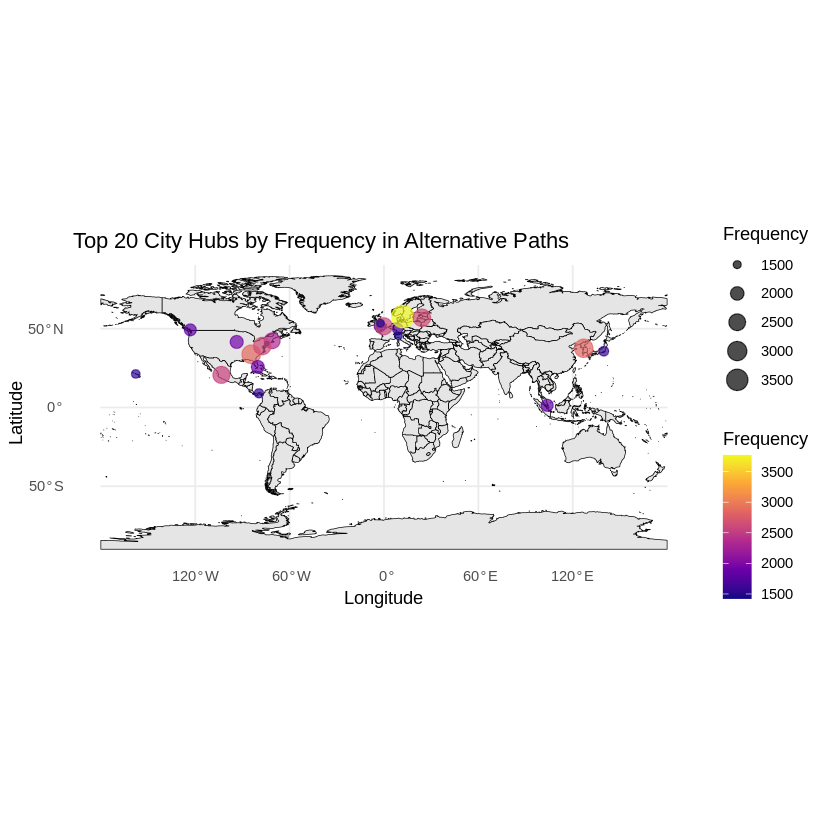

In [22]:
# Plot the top 20 hubs on the world map
ggplot() +
  geom_sf(data=the_world, fill="grey90", color="black", size=0.2) +
  geom_point(data=top_hubs, aes(x=longitude, y=latitude, size=Frequency, color=Frequency), alpha=0.7) +
  scale_color_viridis_c(option="plasma") +
  labs(title="Top 20 City Hubs by Frequency in Alternative Paths",
       x="Longitude", y="Latitude", color="Frequency", size="Frequency") +
  theme_minimal()


# Save the top hubs data to a CSV file
write.csv(top_hubs, "top_20_hubs.csv", row.names = FALSE)
print("Top 20 hubs data saved to top_20_hubs.csv")

### 3. Compute the Average Number of Intermediate Nodes

To estimate path complexity, we calculate how many **intermediate nodes**
each detour (TIV) path passes through.

If a path consists of \( N \) nodes, then the number of intermediate nodes is \( N-2 \),
excluding the source and destination.


In [23]:
# Convert Alternative_path to a character vector
alternative_paths_char <- as.character(combined_data$Alternative_path)

# Compute the number of intermediate nodes per connection
# Split the string by spaces and subtract 2 for the source and destination nodes
combined_data$Num_intermediate_nodes <- sapply(strsplit(alternative_paths_char, " "), length) - 2


# Calculate the average number of intermediate nodes
avg_intermediate_nodes <- mean(combined_data$Num_intermediate_nodes, na.rm = TRUE)

# Print the result
cat("Average number of intermediate nodes per alternative path:", round(avg_intermediate_nodes, 2), "\n")

Average number of intermediate nodes per alternative path: 1.75 


# TIV matrix per region

# 🌐 Compute Regional TIV Matrix (2025)

In this experiment, we analyze the **distribution of TIVs** between
different world regions.

Each pair of regions (source → destination) is evaluated to determine:
1. The **average TIV gain (%)**, representing the mean latency reduction for detour paths.
2. The **TIV ratio**, indicating the percentage of links that exhibit TIV within or between regions.

This produces a *Region–Region Matrix* that summarizes how frequently and how strongly
each region benefits from detour routing.


## Regional TIV Gain (mean latency reduction)

### 1. Prepare dataset for regional analysis

In [53]:
combined_data_v2 = combined_data

In [54]:
combined_data_v2

From   To            Direct    Alternative Improvement 
1     Accra  JoaoPessoa    279.0813  260.4000     18.6813333 
2     Accra  Toronto       204.5738  188.8774     15.6963750 
3     Accra  Tokyo         347.5229  307.0309     40.4920000 
4     Accra  Auckland      396.2890  369.0752     27.2137083 
5     Accra  Stockholm     141.5106  137.8806      3.6300000 
6     Accra  Dallas        221.6955  217.4735      4.2219583 
7     Accra  Boston        179.2765  178.1473      1.1291667 
8     Accra  Miami         214.2836  208.0164      6.2671667 
9     Accra  Washington    189.7562  184.5297      5.2265000 
10    Accra  Barcelona     137.5083  137.3380      0.1702500 
11    Accra  Atlanta       199.0792  197.5273      1.5518750 
12    Accra  Brisbane      387.7156  350.3947     37.3208750 
13    Accra  SanJose       249.6610  239.2868     10.3742500 
14    Accra  Tallinn       144.6277  144.2079      0.4198333 
15    Accra  Copenhagen    134.7395  129.2706      5.4689583 
16    Accra  Milan         138.0523  133.4295      4.6227500 
17    Accra  Ljubljana     145.2176  142.0528      3.1648333 
18    Accra  Fremont       250.9591  239.5050     11.4541250 
19    Accra  Singapore     332.0177  280.2845     51.7332083 
20    Accra  Warsaw        140.9121  139.6343      1.2778750 
21    Accra  Mexico        252.2036  230.9907     21.2128750 
22    Accra  LosAngeles    238.9235  237.5708      1.3527083 
23    Accra  Phoenix       242.5985  235.5645      7.0340000 
24    Accra  Houston       218.5957  210.3735      8.2222083 
25    Accra  Baltimore     189.5205  186.3450      3.1755833 
26    Accra  Helsinki      155.2703  145.1958     10.0744583 
27    Accra  NewDelhi      376.8055  257.0305    119.7750833 
28    Accra  Budapest      139.9875  139.6305      0.3569583 
29    Accra  Bergen        152.4364  145.0650      7.3713750 
30    Accra  Medellin      267.2280  264.8161      2.4119167 
⋮     ⋮      ⋮             ⋮         ⋮           ⋮           
43538 Zurich Bursa          48.95342  38.90558    10.04783333
43539 Zurich Gdansk         30.54658  27.31404     3.23254167
43540 Zurich Brussels       17.95829  16.38563     1.57266667
43541 Zurich PhnomPenh     217.68225 187.92413    29.75812500
43542 Zurich Ktis           22.43108  17.55496     4.87612500
43543 Zurich Bogota        156.96696 156.90400     0.06295833
43544 Zurich Athens         50.30475  41.24104     9.06370833
43545 Zurich Canberra      267.54171 249.87500    17.66670833
43546 Zurich Shenzhen      244.80508 181.50617    63.29891667
43547 Zurich Bangalore     255.93183 144.56166   111.37016848
43548 Zurich Liege          19.33717  17.66550     1.67166667
43549 Zurich Redding       167.57250 152.39225    15.18025000
43550 Zurich Izmir          40.04571  34.36417     5.68154167
43551 Zurich Bristol        30.64321  24.02437     6.61883333
43552 Zurich Indianapolis  120.98337 106.68554    14.29783333
43553 Zurich HoChiMinhCity 201.33808 197.41675     3.92133333
43554 Zurich Cromwell      107.42750 101.31667     6.11083333
43555 Zurich Syracuse      110.69792  89.82433    20.87358333
43556 Zurich Brasilia      221.21379 208.60263    12.61116667
43557 Zurich Savannah      149.38721 130.04975    19.33745833
43558 Zurich Algiers        57.77279  56.75979     1.01300000
43559 Zurich Lagos         116.69750 110.51138     6.18612500
43560 Zurich Koto          228.91529 189.14454    39.77075000
43561 Zurich Valletta       46.02558  36.07192     9.95366667
43562 Zurich Tunis          36.52325  33.23850     3.28475000
43563 Zurich QuebecCity    105.75742  96.83133     8.92608333
43564 Zurich Beirut        173.90367 156.73996    17.16370833
43565 Zurich Quito         176.60333 165.28796    11.31537500
43566 Zurich Jerusalem      71.16813  48.11046    23.05766667
43567 Zurich Zhangjiakou   183.45475 145.77200    37.68275000
      Alternative_path         TIV_present TIV_gain    id  title  location
1     245 127 164 1            TRUE         7.1740911  285 Accra  Accra   
2     245 22

In [55]:
combined_data_v2 <- merge(
  combined_data_v2,
  servers[, c("name", "country")],
  by.x = "From", by.y = "name", all.x = TRUE
)
colnames(combined_data_v2)[colnames(combined_data_v2) == "country"] <- "country_from"

In [56]:
combined_data_v2 <- merge(
  combined_data_v2,
  servers[, c("name", "country")],
  by.x = "To", by.y = "name", all.x = TRUE
)
colnames(combined_data_v2)[colnames(combined_data_v2) == "country"] <- "country_to"

### 2. Assign Countries to Regions

Each country is grouped into one of nine **macro-regions**:
NorthAm, WestEurope, EastEurope, Au&NewZ, LatAm, Africa, MidEast, Hindustan, and PacificC.

This enables a continent-level analysis of TIV patterns across the Internet.


In [57]:
assign_region <- function(country) {
  if (country %in% c("United States", "Canada", "Mexico", "Puerto Rico", "Guatemala", "Panama", "Honduras", "Costa Rica"))
    return("NorthAm")

  if (country %in% c("United Kingdom", "France", "Germany", "Spain", "Greece", "Italy", "Netherlands",
                     "Belgium", "Switzerland", "Austria", "Sweden", "Norway", "Finland", "Denmark",
                     "Ireland", "Portugal", "Luxembourg", "Iceland", "Malta", "Isle of Man"))
    return("WestEurope")

  if (country %in% c("Poland", "Czech Republic", "Hungary", "Romania", "Bulgaria", "Slovakia",
                     "Croatia", "Serbia", "Ukraine", "Lithuania", "Latvia", "Estonia",
                     "Slovenia", "Kosovo", "Moldova", "Russia", "Georgia", "Albania"))
    return("EastEurope")

  if (country %in% c("Australia", "New Zealand"))
    return("Au&NewZ")

  if (country %in% c("Brazil", "Argentina", "Chile", "Colombia", "Peru", "Uruguay",
                     "Ecuador", "Venezuela", "Suriname"))
    return("LatAm")

  if (country %in% c("South Africa", "Egypt", "Nigeria", "Kenya", "Morocco", "Algeria",
                     "Tunisia", "Tanzania", "Ghana", "Uganda"))
    return("Africa")

  if (country %in% c("United Arab Emirates", "Saudi Arabia", "Israel", "Qatar", "Turkey", "Oman",
                     "Kuwait", "Lebanon", "Cyprus"))
    return("MidEast")

  if (country %in% c("India", "Pakistan", "Bangladesh"))
    return("Hindustan")

  if (country %in% c("Japan", "Singapore", "Malaysia", "Indonesia", "China", "Thailand",
                     "Vietnam", "Philippines", "South Korea", "Cambodia", "Taiwan", "Hong Kong", "Kazakhstan"))
    return("PacificC")

  return(NA)
}

# Merge with servers data to get country information for 'From' cities
combined_data_v2 <- merge(combined_data_v2, servers[, c("id", "country")], by.x = "id", by.y = "id", all.x = TRUE)
setnames(combined_data_v2, "country", "country_from")

# Merge with servers data to get country information for 'To' cities
combined_data_v2 <- merge(combined_data_v2, servers[, c("name", "country")], by.x = "To", by.y = "name", all.x = TRUE)
setnames(combined_data_v2, "country", "country_to")


combined_data_v2$region_from <- sapply(combined_data_v2$country_from, assign_region)
combined_data_v2$region_to   <- sapply(combined_data_v2$country_to, assign_region)

In [58]:
names(combined_data_v2) <- make.unique(names(combined_data_v2))

### 3. Compute Regional TIV Gain Ratios**

For each region pair $(R_s, R_d)$, compute:
$$
\text{Average TIV Gain}(R_s, R_d) = \frac{\sum \text{TIV gain values}}{\text{Number of links}}
$$

This shows how much latency improvement (in %) each region achieves on average
when routing traffic via detour paths.


In [59]:
region_matrix_df <- combined_data_v2 %>%
  filter(!is.na(region_from) & !is.na(region_to)) %>%
  group_by(region_from, region_to) %>%
  summarise(
    total_links = n(),
    tiv_links = sum(TIV_gain, na.rm = TRUE),
    tiv_av_TIV_gain = tiv_links / total_links  # percentage
  ) %>%
  ungroup()

`summarise()` has grouped output by 'region_from'. You can override using the
`.groups` argument.


### 4. Create the Regional Matrix

The aggregated table is reshaped into a Region–Region **matrix format**
for easy visualization and export.


In [60]:
region_matrix <- region_matrix_df %>%
  pivot_wider(names_from = region_to, values_from = tiv_av_TIV_gain) %>%
  as.data.frame()

In [61]:
df_sorted <- combined_data_v2 %>%
  arrange(desc(TIV_gain))

In [48]:
df_sorted

To           id  From         Direct    Alternative Improvement 
1     Toronto      184 Pittsburgh    98.48196 11.84850     86.63346   
2     Pittsburgh     2 Toronto       98.86400 12.20142     86.66258   
3     Shanghai      72 HongKong     298.79433 37.80354    260.99079   
4     HongKong     180 Shanghai     298.63833 37.81458    260.82375   
5     Hangzhou      72 HongKong     316.65450 45.71454    270.93996   
6     HongKong      84 Hangzhou     316.24121 45.90000    270.34121   
7     Hangzhou     112 Manila       354.84379 62.60721    292.23658   
8     Manila        84 Hangzhou     354.55983 62.95217    291.60767   
9     HongKong     261 Zhangjiakou  333.57633 63.38517    270.19117   
10    Zhangjiakou   72 HongKong     333.74175 63.64817    270.09358   
11    Shenzhen      72 HongKong     346.90900 67.01496    279.89404   
12    HongKong     221 Shenzhen     346.83529 67.60275    279.23254   
13    Bursa          3 Prague       150.74388 32.81517    117.92871   
14    Prague       205 Bursa        151.38196 32.96363    118.41833   
15    Groningen      3 Prague       100.22875 22.45796     77.77079   
16    Singapore    111 Pune         228.71204 51.34471    177.36734   
17    Prague       197 Groningen    100.23675 22.51975     77.71700   
18    Bratislava   197 Groningen     99.95542 22.47521     77.48021   
19    Groningen    147 Bratislava    99.96733 22.48521     77.48212   
20    Pune          31 Singapore    228.61708 51.44996    177.16712   
21    Zhangjiakou  112 Manila       357.43092 80.54083    276.89008   
22    Shanghai      57 Jakarta      355.65258 80.62854    275.02404   
23    Manila       261 Zhangjiakou  353.28487 80.43733    272.84754   
24    Manila        31 Singapore    178.86237 40.81400    138.04837   
25    Singapore    112 Manila       178.83513 41.33908    137.49604   
26    Jakarta      180 Shanghai     355.94971 82.28650    273.66321   
27    Jacksonville  97 Tampa         46.42579 10.92896     35.49683   
28    Shanghai     112 Manila       227.22917 54.69621    172.53296   
29    Shenzhen     112 Manila       347.96421 83.90762    264.05658   
30    Manila       180 Shanghai     225.58925 54.86675    170.72250   
⋮     ⋮            ⋮   ⋮            ⋮         ⋮           ⋮           
43538 Malaysia      27 Milan        156.66625 156.64933   0.0169166667
43539 Edinburgh     42 CapeTown     154.08750 154.07171   0.0157916667
43540 Bratislava   241 Algiers       47.82071  47.81583   0.0048750000
43541 Piscataway   170 Vilnius       99.24150  99.23237   0.0091250000
43542 Austin         7 Amsterdam    112.82512 112.81592   0.0092083333
43543 Albany       157 Gosport       73.42925  73.42354   0.0057083333
43544 Bergen        55 KansasCity   121.94392 121.93500   0.0089166667
43545 Limassol     246 Valletta      95.74442  95.73763   0.0067916667
43546 Rome         230 Indianapolis 112.06238 112.05458   0.0077916667
43547 Istanbul     109 Scranton     118.78217 118.77454   0.0076250000
43548 Denver       156 Maidstone    104.93846 104.93196   0.0065000000
43549 Zagreb        40 Baltimore     99.96654  99.96096   0.0055833333
43550 Athens       203 Hamburg       46.19512  46.19258   0.0025416667
43551 Tokyo        177 Guadalajara  157.60858 157.60133   0.0072500000
43552 Zhangjiakou   30 Fremont      155.24983 155.24392   0.0059166667
43553 Accra         44 Lisbon       143.80562 143.80050   0.0051250000
43554 Kampala      216 TheHague     139.63442 139.62971   0.0047083333
43555 Jacksonville 191 Cardiff      100.15992 100.15683   0.0030833333
43556 Beirut       118 Kampala      271.21550 271.20808   0.0074166667
43557 DesMoines      2 Toronto       24.89104  24.89037   0.0006666667
43558 Quito         40 Baltimore     77.86379  77.86179   0.0020000000
43559 Brunswick    175 Johannesburg 227.58017 227.57442   0.0057500000
43560 Scranton     230 Indianapolis  29.09933  29.09862   0.0007083333
43561 Accra        236 Basel        132.15613 132.15387   0.0022500000
43562 Bergen       191 Cardiff

In [62]:
region_matrix_df

region_from region_to  total_links tiv_links   tiv_av_TIV_gain
1  Africa      Africa       59         1652.72423 28.012275      
2  Africa      Au&NewZ      86         1316.39563 15.306926      
3  Africa      EastEurope  207         3392.37830 16.388301      
4  Africa      Hindustan    70         2400.89060 34.298437      
5  Africa      LatAm       102          895.08617  8.775355      
6  Africa      MidEast      88         1251.84344 14.225494      
7  Africa      NorthAm     737         6083.18233  8.253979      
8  Africa      PacificC    196         4683.75146 23.896691      
9  Africa      WestEurope  429         6387.00180 14.888116      
10 Au&NewZ     Africa       85         1294.23992 15.226352      
11 Au&NewZ     Au&NewZ      14           39.27952  2.805680      
12 Au&NewZ     EastEurope  194         2391.44455 12.327034      
13 Au&NewZ     Hindustan    58         1686.47135 29.077092      
14 Au&NewZ     LatAm        82          864.82105 10.546598      
15 Au&NewZ     MidEast      82          813.06502  9.915427      
16 Au&NewZ     NorthAm     613         5818.02813  9.491074      
17 Au&NewZ     PacificC    149         6544.30432 43.921506      
18 Au&NewZ     WestEurope  485         5566.58119 11.477487      
19 EastEurope  Africa      205         3404.63801 16.607990      
20 EastEurope  Au&NewZ     192         2390.64386 12.451270      
21 EastEurope  EastEurope  302         6534.07286 21.636003      
22 EastEurope  Hindustan   185         4729.01382 25.562237      
23 EastEurope  LatAm       233         1878.93766  8.064110      
24 EastEurope  MidEast     199         5664.88551 28.466761      
25 EastEurope  NorthAm    1648        13072.10577  7.932103      
26 EastEurope  PacificC    446        14669.62321 32.891532      
27 EastEurope  WestEurope  980        15633.75560 15.952812      
28 Hindustan   Africa       69         2380.49199 34.499884      
29 Hindustan   Au&NewZ      58         1608.58608 27.734243      
30 Hindustan   EastEurope  187         4900.78463 26.207404      
⋮  ⋮           ⋮          ⋮           ⋮           ⋮              
52 MidEast     NorthAm     709         5149.544    7.263109      
53 MidEast     PacificC    184         5924.499   32.198366      
54 MidEast     WestEurope  476         8141.522   17.104038      
55 NorthAm     Africa      733         5909.936    8.062669      
56 NorthAm     Au&NewZ     616         5882.349    9.549267      
57 NorthAm     EastEurope 1653        13503.223    8.168919      
58 NorthAm     Hindustan   583         7569.205   12.983198      
59 NorthAm     LatAm       710         8561.418   12.058335      
60 NorthAm     MidEast     716         5497.195    7.677647      
61 NorthAm     NorthAm    3789        69706.735   18.397133      
62 NorthAm     PacificC   1465        21240.347   14.498531      
63 NorthAm     WestEurope 4168        35458.446    8.507305      
64 PacificC    Africa      196         4630.193   23.623435      
65 PacificC    Au&NewZ     150         6515.071   43.433809      
66 PacificC    EastEurope  443        14696.862   33.175762      
67 PacificC    Hindustan   127         7631.584   60.091212      
68 PacificC    LatAm       192         2773.699   14.446351      
69 PacificC    MidEast     186         5914.513   31.798459      
70 PacificC    NorthAm    1457        20615.039   14.148963      
71 PacificC    PacificC    278        26640.904   95.830591      
72 PacificC    WestEurope 1145        34027.287   29.718155      
73 WestEurope  Africa      431         5926.946   13.751614      
74 WestEurope  Au&NewZ     482         5533.158   11.479580      
75 WestEurope  EastEurope  971        15643.739   16.110957      
76 WestEurope  Hindustan   440        14382.606   32.687741      
77 WestEurope  LatAm       634         4963.097    7.828228      
78 WestEurope  MidEast     496         8408.369   16.952357      
79 WestEurope  NorthAm    4171        34509.849    8.273759      
80 WestEurope  PacificC   1149        34109

### 5. Visualize as Heatmap

This heatmap displays the **average TIV gain (%)** between each pair of regions.
Bright yellow areas indicate regions that experience the highest relative RTT reductions.


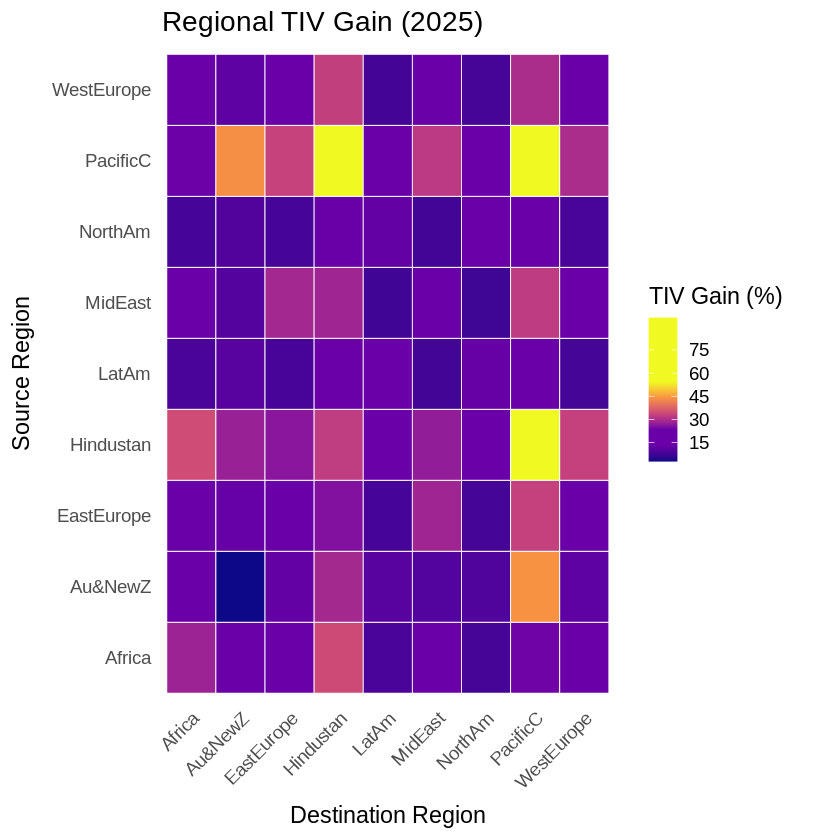

In [71]:
ggplot(region_matrix_df, aes(x = region_to, y = region_from, fill = tiv_av_TIV_gain)) +
  geom_tile(color = "white") +
  scale_fill_gradientn(
    name = "TIV Gain (%)",

    colours = c(
      "#0D0887",  # deep blue
      "#6A00A8",
      "#6A00A8",  # violet
      "#CB4679",  # magenta
      "#F89441",  # orange
      "#F0F921",
      "#F0F921",
      "#F0F921",
      "#F0F921" ,
      "#F0F921"   # yellow
    ),
    breaks = seq(0, 80, by = 15),          # consistent tick spacing

  ) +
  labs(
    title = "Regional TIV Gain (2025)",
    x = "Destination Region",
    y = "Source Region"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    panel.grid = element_blank()
  )



### 6. Export Matrix Data

In [72]:
write.csv(region_matrix_df, "Regional_TIV_Matrix_2025.csv", row.names = FALSE)


## Regional TIV Ratio (Percentage of Links Exhibiting TIV)

In this experiment, we compute the **TIV Ratio** between world regions.  
For each source region $R_s$ and destination region $R_d$, the TIV ratio is defined as:

$$
\rho(R_s, R_d) = \frac{N_{\text{TIV}}(R_s, R_d)}{N_{\text{total}}(R_s, R_d)} \times 100\%
$$

where:

- $N_{\text{TIV}}(R_s, R_d)$ = number of source–destination links that exhibited a TIV  
- $_{\text{total}}(R_s, R_d)$ = total number of measured links between the two regions  

This matrix highlights **where in the world TIVs are most common**, complementing the earlier matrix of **average TIV gain **.



### 1. Compute TIV Ratio per Region Pair

In [77]:
combined_data_v2 <- alternative_paths_all_data


combined_data_v2 <- merge(
  combined_data_v2,
  servers[, c("name", "country")],
  by.x = "From", by.y = "name", all.x = TRUE
)
colnames(combined_data_v2)[colnames(combined_data_v2) == "country"] <- "country_from"

combined_data_v2 <- merge(
  combined_data_v2,
  servers[, c("name", "country")],
  by.x = "To", by.y = "name", all.x = TRUE
)
colnames(combined_data_v2)[colnames(combined_data_v2) == "country"] <- "country_to"

combined_data_v2$region_from <- sapply(combined_data_v2$country_from, assign_region)
combined_data_v2$region_to   <- sapply(combined_data_v2$country_to, assign_region)

region_matrix_df <- combined_data_v2 %>%
  filter(!is.na(region_from) & !is.na(region_to)) %>%
  group_by(region_from, region_to) %>%
  summarise(
    total_links = n(),
    tiv_links = sum(TIV_present, na.rm = TRUE),
    tiv_ratio = tiv_links / total_links * 100  # percentage
  ) %>%
  ungroup()

`summarise()` has grouped output by 'region_from'. You can override using the
`.groups` argument.


In [78]:
region_matrix <- region_matrix_df %>%
  pivot_wider(names_from = region_to, values_from = tiv_ratio) %>%
  as.data.frame()

   region_from total_links tiv_links   Africa  Au&NewZ EastEurope Hindustan
1       Africa         110        59 53.63636       NA         NA        NA
2       Africa          99        86       NA 86.86869         NA        NA
3       Africa         297       207       NA       NA   69.69697        NA
4       Africa          88        70       NA       NA         NA  79.54545
5       Africa         132       102       NA       NA         NA        NA
6       Africa         110        88       NA       NA         NA        NA
7       Africa         913       737       NA       NA         NA        NA
8       Africa         231       196       NA       NA         NA        NA
9       Africa         715       429       NA       NA         NA        NA
10     Au&NewZ          99        85 85.85859       NA         NA        NA
11     Au&NewZ          72        14       NA 19.44444         NA        NA
12     Au&NewZ         243       194       NA       NA   79.83539        NA
13     Au&Ne

### 2. Visualize TIV Ratios as Heatmap

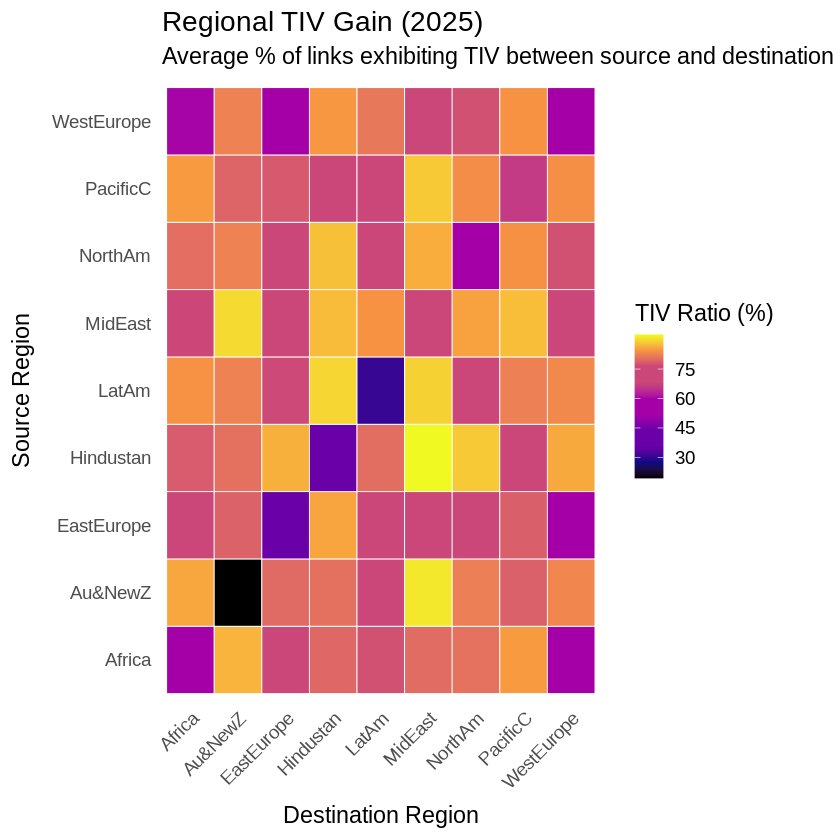

In [81]:
############################################################
# 5. Optional: visualize as heatmap
############################################################

ggplot(region_matrix_df, aes(x = region_to, y = region_from, fill = tiv_ratio)) +
  geom_tile(color = "white") +
  scale_fill_gradientn(
    name = "TIV Ratio (%)",
    colours = c(
      "black",
      "#0D0887",  # deep blue
      "#6A00A8",
      "#6A00A8",
      "#A500A8",  # violet#
      "#A500A8",  # violet
      "#CB4679",
      "#CB4679",  # magenta
      "#F89441",  # orange
      "#F0F921"   # yellow
    ),
    breaks = seq(0, 80, by = 15),          # consistent tick spacing

  ) +
  labs(
    title = "Regional TIV Ratio (2025)",
    subtitle = "Average % of links exhibiting TIV between source and destination regions",
    x = "Destination Region",
    y = "Source Region"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    panel.grid = element_blank()
  )



### 3. Export Data

In [80]:
write.csv(region_matrix_df, "Regional_TIV_Matrix_2025.csv", row.names = FALSE)